<a href="https://colab.research.google.com/github/DDGUZMANO/Lesiones_NBA_2010-2020/blob/main/TP6/Lesiones_NBA_2010_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

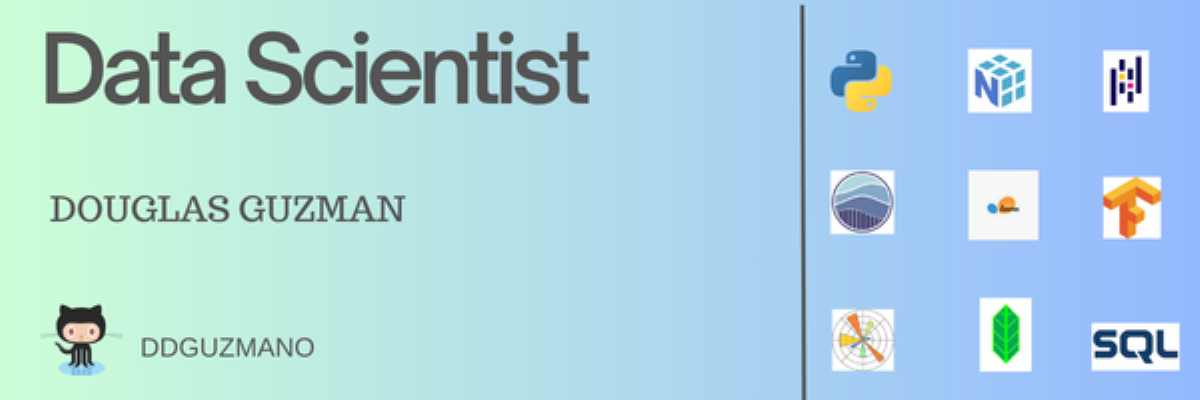

# Analisis exploratorio de datos

En este Notebook analizaremos las lesiones deportivas que sufrieron los jugadores de los diferentes equipos de la NBA durante el periodo de la temporada 2010-2011 hasta la temporada 2019-2020. Buscando de esta manera responder algunas preguntas como:


*   En que temporadas se ocasionaron más lesiones?
*   Cuales fueron los equipos que sufrieron el mayor número de lesiones en sus jugadores?
*   Algunos factores como la cantidad de partidos jugados o la ubicación geográfica influyen en la cantidad de lesiones en los equipos?

El datasets de estudio será, injuries_2010-2020.csv, descargado desde Kaggle cuyo propietario es Randall Hopkins. De ser necesario, lo complementaremos con información descargada desde wikipedia, dependiendo de nuestras necesidades.



In [53]:
# Importación de librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import folium
import plotly.express as px

In [54]:
# Montamos nuestro google drive al colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# Abrimos el dataset como un dataframe de pandas

DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/Data/injuries_2010-2020.csv'
df_injuries = pd.read_csv(DATA_DIR)

In [56]:
# Primeramente veremos la información que nos presenta el dataframe

df_injuries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27105 entries, 0 to 27104
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          27105 non-null  object
 1   Team          27103 non-null  object
 2   Acquired      9542 non-null   object
 3   Relinquished  17560 non-null  object
 4   Notes         27105 non-null  object
dtypes: object(5)
memory usage: 1.0+ MB


El dataframe tiene un total de 27105 entradas y 5 columnas.
**Observación:** Podemos ver que las columnas Team, Acquired y Relinquished tienen valores NaN.

In [57]:
# Veamos las primeras cinco entradas del dataframe

df_injuries.head()

,Date,Team,Acquired,Relinquished,Notes
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely)


In [58]:
# Veamos las últimas cinco entradas del dataframe

df_injuries.tail()

,Date,Team,Acquired,Relinquished,Notes
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD)
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left ...
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL
27104,2020-10-06,Heat,Bam Adebayo,NaN,returned to lineup


La columna **Date** indica la fecha de la entrada. Con el .info() que aplicamos al dataframe unas lineas atras pudimos ver que esta columna es tipo object, tendremos que convertirla a tipo datetime.

La columna **Team** indica el equipo del jugador relacionado con la lesión.

Podemos entender que la columna **Relinquished** nos indica el nombre del jugador que fue declarado lesionado y la columna **Acquired** nos indica el nombre del jugador cuando fue activado como disponible para jugar.

La columna **Notes** explica el evento, como podemos entender puede ser el nombre de la lesión o la puesta a disposición del jugador posterior a la lesión.



In [59]:
# Convertimos la columna Date a datetime.
# Con el argumento errors = 'coerce', los datos que no puedan ser convertidos datetime
# porque no se ajuste al formato especificado, se guardara como NaT

df_injuries['Date'] = pd.to_datetime(df_injuries['Date'], format='%Y-%m-%d', errors='coerce')

In [60]:
# Verificamos que se modificó el tipo de dato de la columna Date

df_injuries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27105 entries, 0 to 27104
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          27105 non-null  datetime64[ns]
 1   Team          27103 non-null  object        
 2   Acquired      9542 non-null   object        
 3   Relinquished  17560 non-null  object        
 4   Notes         27105 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.0+ MB


In [61]:
# Verificamos cuantos tipos de tipos de datos distintos tenemos en la columna Date

n_datos = len(df_injuries['Date'].isna().unique())
print(f'Hay {n_datos} tipos de datos en la columna "Date"')

Hay 1 tipos de datos en la columna "Date"


Con el objetivo de identificar el número de lesiones por cada temporada, tendremos que separar las fechas en una nueva columna llamada **Temporada**, donde tomaremos como inicio el mes de octubre y como final de temporada el mes de agosto del siguiente año (se toma en cuenta la temporada regular, play offs y finales).
Por ejemplo, la temporada 2010 inicia en abril de 2010 y finaliza en agosto del 2011.

In [62]:
# Creamos la columan Temporada de tipo datetime
df_injuries['Temporada'] = pd.to_datetime(df_injuries['Date']).dt.year

# Ajustar la temporada para los meses de octubre a diciembre
df_injuries.loc[pd.to_datetime(df_injuries['Date']).dt.month.between(1, 9), 'Temporada'] -= 1

# Crear columnas adicionales para indicar si la fecha está en la temporada regular, playoffs o finales
df_injuries['Regular'] = (pd.to_datetime(df_injuries['Date']).dt.month.between(10, 12)) | (pd.to_datetime(df_injuries['Date']).dt.month.between(1, 4))
df_injuries['Playoffs'] = pd.to_datetime(df_injuries['Date']).dt.month.between(4, 6)
df_injuries['Finales'] = pd.to_datetime(df_injuries['Date']).dt.month.between(6, 8)

# Mostrar el DataFrame resultante
df_injuries.head()

,Date,Team,Acquired,Relinquished,Notes,Temporada,Regular,Playoffs,Finales
0,2010-10-03,Bulls,NaN,Carlos Boozer,fractured bone in right pinky finger (out inde...,2010,True,False,False
1,2010-10-06,Pistons,NaN,Jonas Jerebko,torn right Achilles tendon (out indefinitely),2010,True,False,False
2,2010-10-06,Pistons,NaN,Terrico White,broken fifth metatarsal in right foot (out ind...,2010,True,False,False
3,2010-10-08,Blazers,NaN,Jeff Ayres,torn ACL in right knee (out indefinitely),2010,True,False,False
4,2010-10-08,Nets,NaN,Troy Murphy,strained lower back (out indefinitely),2010,True,False,False


Para la temporada 2019 tuvimos la pandemia del covid, por lo que el calendario de los partidos de la NBA fue significativamente modificado.
La temporada regular tuvo inicio en octubre de 2019 y final en agosto de 2020, los play offs fueron desde agosto hasta octubre y las finales se jugaron en octubre de 2020.

In [63]:
df_injuries.tail(10)

,Date,Team,Acquired,Relinquished,Notes,Temporada,Regular,Playoffs,Finales
27095,2020-09-12,Rockets,NaN,Tyson Chandler,placed on IL with neck spasms (out for season),2019,False,False,False
27096,2020-09-18,Celtics,NaN,Romeo Langford,placed on IL with strained right adductor (out...,2019,False,False,False
27097,2020-09-22,Celtics,NaN,Romeo Langford,surgery on right wrist (out for season),2019,False,False,False
27098,2020-09-23,Heat,NaN,Gabe Vincent,sore right knee (DTD),2019,False,False,False
27099,2020-09-30,Heat,NaN,Bam Adebayo,strained left shoulder (DTD),2019,False,False,False
27100,2020-09-30,Lakers,Dion Waiters,NaN,activated from IL,2019,False,False,False
27101,2020-10-02,Heat,NaN,Bam Adebayo,strained neck (DTD),2020,True,False,False
27102,2020-10-02,Heat,NaN,Goran Dragic,placed on IL with torn plantar fascia in left ...,2020,True,False,False
27103,2020-10-02,Heat,Chris Silva,NaN,activated from IL,2020,True,False,False
27104,2020-10-06,Heat,Bam Adebayo,NaN,returned to lineup,2020,True,False,False


Modificamos las fechas de inicio y final de temporada para la edición del 2019, en las columnas **Temporada**, **Regular**, **Playoffs** y **Finales**.

In [64]:
df_injuries['Temporada'] = df_injuries['Temporada'].replace({2020: 2019})
df_injuries['Temporada'].loc[pd.to_datetime(df_injuries['Date']).between('2019-10-22', '2020-10-11')] = 2019
df_injuries['Regular'] = pd.to_datetime(df_injuries['Date']).between('2019-10-10', '2020-08-14')
df_injuries['Playoffs'] = pd.to_datetime(df_injuries['Date']).between('2020-08-17', '2020-09-30')
df_injuries['Finales'] = pd.to_datetime(df_injuries['Date']).between('2020-10-01', '2020-10-11')


<ipython-input-64-cb67202d0b09>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
# Verificamos que fueron tomados los valores correspondientes

df_injuries.tail(15)

,Date,Team,Acquired,Relinquished,Notes,Temporada,Regular,Playoffs,Finales
27090,2020-09-08,Lakers,NaN,Dion Waiters,placed on IL with left groin injury,2019,False,True,False
27091,2020-09-08,Bucks,Giannis Antetokounmpo,NaN,returned to lineup,2019,False,True,False
27092,2020-09-08,Bucks,NaN,Giannis Antetokounmpo,sprained right ankle (DTD),2019,False,True,False
27093,2020-09-10,Lakers,NaN,JaVale McGee,sprained left ankle (DTD),2019,False,True,False
27094,2020-09-12,Lakers,JaVale McGee,NaN,returned to lineup,2019,False,True,False
27095,2020-09-12,Rockets,NaN,Tyson Chandler,placed on IL with neck spasms (out for season),2019,False,True,False
27096,2020-09-18,Celtics,NaN,Romeo Langford,placed on IL with strained right adductor (out...,2019,False,True,False
27097,2020-09-22,Celtics,NaN,Romeo Langford,surgery on right wrist (out for season),2019,False,True,False
27098,2020-09-23,Heat,NaN,Gabe Vincent,sore right knee (DTD),2019,False,True,False
27099,2020-09-30,Heat,NaN,Bam Adebayo,strained left shoulder (DTD),2019,False,True,False


Veamos como se distribuyen las cantidades de lesiones por temporada

In [66]:
# Para esto nos quedaremos con la columna 'Relinquished' (que expresa el momento en que empieza
# la lesion del jugador) y la columna 'Temporada' y eliminaremos los valores NaN de la columna
# 'Relinquished'

df_solo_lesiones = df_injuries[['Relinquished','Temporada']]
print(df_solo_lesiones.shape)
dfsolo_lesiones_sin_nulos = df_solo_lesiones.dropna()
print(dfsolo_lesiones_sin_nulos.shape)


(27105, 2)
(17560, 2)


In [67]:
# Verificamos que no existan valores NaN en la columna 'Relinquished'

hay_nan = dfsolo_lesiones_sin_nulos['Relinquished'].isna().any()
print("¿Hay valores NaN en la columna 'Nombre_Columna'? ", hay_nan)

¿Hay valores NaN en la columna 'Nombre_Columna'?  False


In [68]:
# Agruparemos las lesiones por temporada así podremos graficar los resuldaos

df_temp_lesiones = dfsolo_lesiones_sin_nulos.groupby(dfsolo_lesiones_sin_nulos['Temporada']).count()

df_temp_lesiones.head()

,Relinquished
Temporada,
2010,1775
2011,1941
2012,1861
2013,2404
2014,1451


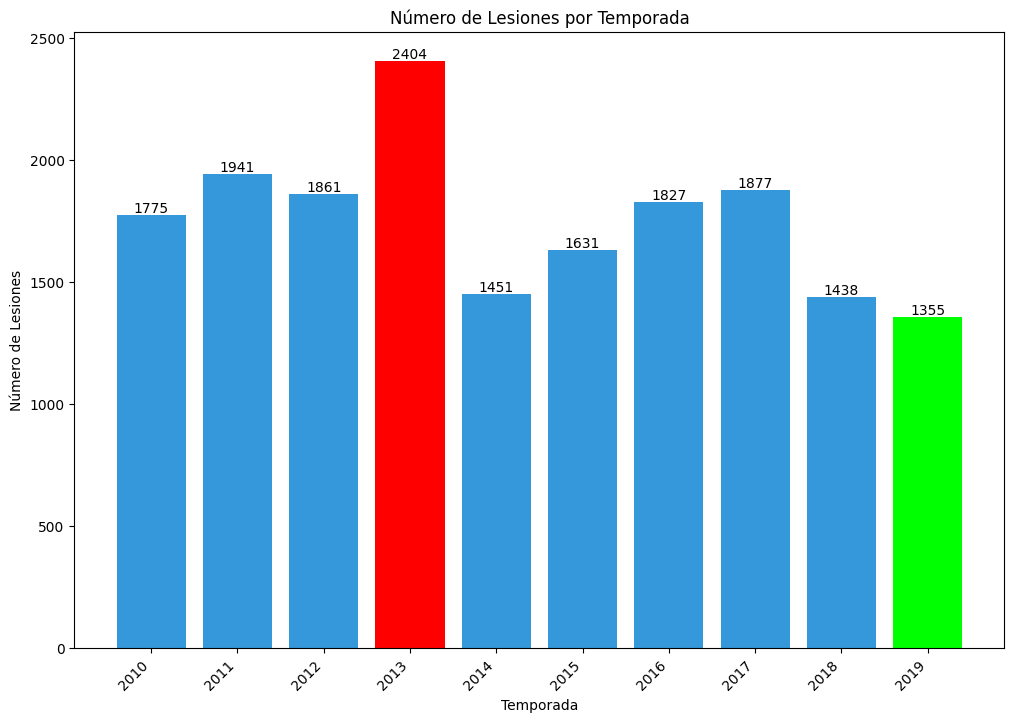

In [69]:
# Procedemos a realizar un gráfico de barras entre el número de lesiones y las temporadas
# usaremos pyplot de matplotlib

plt.figure(figsize=(12, 8))

temporada_max_lesiones = df_temp_lesiones['Relinquished'].idxmax()
temporada_min_lesiones = df_temp_lesiones['Relinquished'].idxmin()

bar_plot = plt.bar(df_temp_lesiones.index, df_temp_lesiones['Relinquished'], color=['#FF0000' if index == temporada_max_lesiones else '#00FF00' if index == temporada_min_lesiones else '#3498db' for index in df_temp_lesiones.index])

plt.xlabel('Temporada')
plt.ylabel('Número de Lesiones')
plt.title('Número de Lesiones por Temporada')

plt.xticks(df_temp_lesiones.index, rotation=45, ha='right')

for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')


plt.show()

Podemos ver que existe una enorme diferencia entre el número de lesiones del año 2013 y el del año 2019.
Nos apoyaremos en un dataset de wikipedia para conocer la cantindad de partidos que hubo en cada una de las temporadas y ver si este factor pudo influir en el número de lesiones.

In [70]:
# URL de la página de Wikipedia que contiene la tabla
url = 'https://es.wikipedia.org/wiki/Temporadas_de_la_NBA'

# Realizar la solicitud HTTP y obtener el contenido de la página
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# La funcion soup nos permite encontrar la tabla por su clase o atributo

tabla_wikipedia = soup.find('table', {'class': 'wikitable'})

# Leer la tabla en un DataFrame de pandas
df_wiki = pd.read_html(str(tabla_wikipedia))[0]

df_wiki.head()

,Temp.,Mejor balance,Récord,Año,Campeón Este,Campeón Oeste,Año,Campeón,N.º de equipos,N.º de partidos,Notas,Ref.
,Temp. regular,Temp. regular,Temp. regular,Playoffs,Playoffs,Playoffs,Finales,Finales,N.º de equipos,N.º de partidos,Notas,Ref.
0,1946-47,Washington Capitols (1),NaN,1947,Philadelphia Warriors,Chicago Stags (1),1947,Philadelphia Warriors,11,60,Temporada inaugural con 11 equipos,[1]​
1,1947-48,St. Louis Bombers (1),NaN,1948,Philadelphia Warriors,Baltimore Bullets (1),1948,Baltimore Bullets[n. 1]​(1),8,48,4 equipos desaparecidos; 1 equipo de la ABL se...,[2]​
2,1948-49,Rochester Royals,NaN,1949,Washington Capitols (1),Minneapolis Lakers,1949,Minneapolis Lakers,12,60,4 equipos de la NBL se unieron,[3]​
3,1949-50,Syracuse Nationals,NaN,1950,Syracuse Nationals,Anderson Packers (1),1950,Minneapolis Lakers,17,64,NBL se fusionó con la BAA and y fue renombrada...,[4]​
4,1950-51,Minneapolis Lakers,NaN,1951,New York Knicks,Rochester Royals (1),1951,Rochester Royals (1),11,68,6 equipos desaparecidos; 1 durante la temporad...,[6]​


In [71]:
# Obtenemos un poco de información sobre este dataset

df_wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   (Temp., Temp. regular)              77 non-null     object
 1   (Mejor balance, Temp. regular)      77 non-null     object
 2   (Récord, Temp. regular)             2 non-null      object
 3   (Año, Playoffs)                     77 non-null     int64 
 4   (Campeón Este, Playoffs)            77 non-null     object
 5   (Campeón Oeste, Playoffs)           77 non-null     object
 6   (Año, Finales)                      77 non-null     int64 
 7   (Campeón, Finales)                  77 non-null     object
 8   (N.º de equipos, N.º de equipos)    77 non-null     int64 
 9   (N.º de partidos, N.º de partidos)  77 non-null     object
 10  (Notas, Notas)                      31 non-null     object
 11  (Ref., Ref.)                        73 non-null     object
d

In [72]:
'''Para los fines que queremos no vamos a necesitar todas las columnas, por lo que eliminaremos
algunas de ellas.'''

print(df_wiki.columns)

MultiIndex([(          'Temp.',   'Temp. regular'),
            (  'Mejor balance',   'Temp. regular'),
            (         'Récord',   'Temp. regular'),
            (            'Año',        'Playoffs'),
            (   'Campeón Este',        'Playoffs'),
            (  'Campeón Oeste',        'Playoffs'),
            (            'Año',         'Finales'),
            (        'Campeón',         'Finales'),
            ( 'N.º de equipos',  'N.º de equipos'),
            ('N.º de partidos', 'N.º de partidos'),
            (          'Notas',           'Notas'),
            (           'Ref.',            'Ref.')],
           )


Para este caso solo tomaremos en cuenta las columnas **N de partidos** y **Temp**.

In [73]:
# Nos quedamos con las columnas que nos dan la información sobre las temporadas y los números de partidos

columnas = df_wiki[[('Temp.', 'Temp. regular'), ('N.º de partidos', 'N.º de partidos')]]

# Crear un nuevo DataFrame con las columnas seleccionadas
df_n_partidos = pd.DataFrame(columnas)
df_n_partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   (Temp., Temp. regular)              77 non-null     object
 1   (N.º de partidos, N.º de partidos)  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [74]:
# Veamos las primeras filas de este dataset

df_n_partidos.head()

,Temp.,N.º de partidos
,Temp. regular,N.º de partidos
0,1946-47,60
1,1947-48,48
2,1948-49,60
3,1949-50,64
4,1950-51,68


Podemos observar que la columna de temporadas no se encuentra en un formato compatible al formato de temporadas de nuestro primer dataset, intentaremos trabajar sobre esta columna para dejarla lo más parecido posible al dataset df_injuries

In [75]:
'''Crearemos una columna de inicio y una de fin, para ajustar las temporadas a los inicios y
finales de las temporadas de la NBA'''

df_n_partidos[['Inicio', 'Fin']] = df_n_partidos[('Temp.', 'Temp. regular')].str.split('-', expand=True)

# Crear columnas con fechas de inicio y fin
df_n_partidos['Inicio'] = pd.to_datetime(df_n_partidos['Inicio'].astype(str), format='%Y')
df_n_partidos['Fin'] = df_n_partidos['Fin'].apply(lambda x: int(x) + 2000 if len(x) == 2 and int(x) < 23 else int(x) + 1900)
df_n_partidos['Fin'] = pd.to_datetime(df_n_partidos['Fin'].astype(str), format='%Y', errors='coerce')

df_n_partidos.head()


,Temp.,N.º de partidos,Inicio,Fin
,Temp. regular,N.º de partidos,,
0,1946-47,60,1946-01-01,1947-01-01
1,1947-48,48,1947-01-01,1948-01-01
2,1948-49,60,1948-01-01,1949-01-01
3,1949-50,64,1949-01-01,1950-01-01
4,1950-51,68,1950-01-01,1951-01-01


In [76]:
# Nos quedamos con las filas que concuerden con los años desde 2010 a 2020

df_2010_2020 = df_n_partidos[
    (df_n_partidos['Inicio'] >= '2009-10-26') &  # Inicio de la temporada 2010-2011
    (df_n_partidos['Fin'] <= '2020-06-30')]   # Fin de la tempora

df_2010_2020.head()

,Temp.,N.º de partidos,Inicio,Fin
,Temp. regular,N.º de partidos,,
64,2010-11,82,2010-01-01,2011-01-01
65,2011-12,66,2011-01-01,2012-01-01
66,2012-13,82,2012-01-01,2013-01-01
67,2013-14,82,2013-01-01,2014-01-01
68,2014-15,82,2014-01-01,2015-01-01


In [77]:
# Ajustamos las columnas de inicio y fin a las fechas aproximadas de inicios y finales de temporada

df_2010_2020['Inicio'] = df_2010_2020['Inicio'].apply(lambda x: x.replace(month=10, day=26))
df_2010_2020['Fin'] = df_2010_2020['Fin'].apply(lambda x: x.replace(month=6, day=30))
df_2010_2020.head(20)

<ipython-input-77-78a3c6440d07>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-77-78a3c6440d07>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Temp.,N.º de partidos,Inicio,Fin
,Temp. regular,N.º de partidos,,
64,2010-11,82,2010-10-26,2011-06-30
65,2011-12,66,2011-10-26,2012-06-30
66,2012-13,82,2012-10-26,2013-06-30
67,2013-14,82,2013-10-26,2014-06-30
68,2014-15,82,2014-10-26,2015-06-30
69,2015-16,82,2015-10-26,2016-06-30
70,2016-17,82,2016-10-26,2017-06-30
71,2017-18,82,2017-10-26,2018-06-30
72,2018-19,82,2018-10-26,2019-06-30


In [78]:
# Eliminamos la última fila porque no entra en el rango que queremos

df_2010_2020 = df_2010_2020.drop(76)
df_2010_2020.head(15)

,Temp.,N.º de partidos,Inicio,Fin
,Temp. regular,N.º de partidos,,
64,2010-11,82,2010-10-26,2011-06-30
65,2011-12,66,2011-10-26,2012-06-30
66,2012-13,82,2012-10-26,2013-06-30
67,2013-14,82,2013-10-26,2014-06-30
68,2014-15,82,2014-10-26,2015-06-30
69,2015-16,82,2015-10-26,2016-06-30
70,2016-17,82,2016-10-26,2017-06-30
71,2017-18,82,2017-10-26,2018-06-30
72,2018-19,82,2018-10-26,2019-06-30


In [79]:
# Modificamos la columna de temporada para que se parezca a la que tenemos en el dataset df_injuries
# y hacemos reset de los indices

df_2010_2020[['Temporada', 'borrar']] = df_2010_2020[('Temp.', 'Temp. regular')].str.split('-', expand=True)
df_2010_2020 = df_2010_2020.drop([('Temp.', 'Temp. regular'),'borrar'],axis = 1)
df_2010_2020.reset_index(drop=True, inplace=True)
df_2010_2020.head()

<ipython-input-79-634d115cfe8a>:5: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,N.º de partidos,Inicio,Fin,Temporada
,N.º de partidos,,,
0,82,2010-10-26,2011-06-30,2010
1,66,2011-10-26,2012-06-30,2011
2,82,2012-10-26,2013-06-30,2012
3,82,2013-10-26,2014-06-30,2013
4,82,2014-10-26,2015-06-30,2014


In [80]:
# Por comodidad modificamos el nombre de la columna que se refiere al número de partidos

df_2010_2020.rename(columns = {'N.º de partidos':'N_partidos'}, inplace = True)

df_2010_2020.head()

,N_partidos,Inicio,Fin,Temporada
,N_partidos,,,
0,82,2010-10-26,2011-06-30,2010
1,66,2011-10-26,2012-06-30,2011
2,82,2012-10-26,2013-06-30,2012
3,82,2013-10-26,2014-06-30,2013
4,82,2014-10-26,2015-06-30,2014


In [81]:
print(df_2010_2020.info())
print(df_temp_lesiones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   (N_partidos, N_partidos)  10 non-null     object        
 1   (Inicio, )                10 non-null     datetime64[ns]
 2   (Fin, )                   10 non-null     datetime64[ns]
 3   (Temporada, )             10 non-null     object        
dtypes: datetime64[ns](2), object(2)
memory usage: 448.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 2010 to 2019
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Relinquished  10 non-null     int64
dtypes: int64(1)
memory usage: 160.0 bytes
None


In [82]:
'''Uniremos el dataset df_temp_lesiones con el dataset df_2010_2020 con el objetivo de
hacer un scatter plot que permita ver graficamente si el número de partidos tiene alguna
influencia sobre el número de lesiones por temporada'''

print(df_2010_2020.info())
print(df_temp_lesiones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   (N_partidos, N_partidos)  10 non-null     object        
 1   (Inicio, )                10 non-null     datetime64[ns]
 2   (Fin, )                   10 non-null     datetime64[ns]
 3   (Temporada, )             10 non-null     object        
dtypes: datetime64[ns](2), object(2)
memory usage: 448.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 2010 to 2019
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Relinquished  10 non-null     int64
dtypes: int64(1)
memory usage: 160.0 bytes
None


Se puede ver que la columna **Temporada** tiene distintos tipos de valores entre los dos dataset, lo que significa que para poder hacerle merge tendremos que convertir el tipo de dato de una de estas columnas con la inteción de hacerlos compatible.

In [83]:
df_2010_2020['Temporada'] = df_2010_2020['Temporada'].astype(int)
df_merge = pd.merge(df_temp_lesiones,df_2010_2020, on = 'Temporada')
df_merge.head(10)

<ipython-input-83-e35be541ba7f>:2: FutureWarning:

merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)

<ipython-input-83-e35be541ba7f>:2: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



,Temporada,Relinquished,"(N_partidos, N_partidos)","(Inicio, )","(Fin, )"
0,2010,1775,82,2010-10-26,2011-06-30
1,2011,1941,66,2011-10-26,2012-06-30
2,2012,1861,82,2012-10-26,2013-06-30
3,2013,2404,82,2013-10-26,2014-06-30
4,2014,1451,82,2014-10-26,2015-06-30
5,2015,1631,82,2015-10-26,2016-06-30
6,2016,1827,82,2016-10-26,2017-06-30
7,2017,1877,82,2017-10-26,2018-06-30
8,2018,1438,82,2018-10-26,2019-06-30
9,2019,1355,72-74,2019-10-26,2020-06-30


La temporada 2019-2020 presentó algunos equipos que jugaron 72 partidos y otros 74, para efectos de estudios modificaremos este valor, tomando el promedio entre estos dos números. También crearemos una copia de la columna no multindexada de N_partidos para que sea mas comodo trabajar y eliminaremos la actual para evitar redundancia.

In [84]:
df_merge['N_partidos'] = df_merge[('N_partidos', 'N_partidos')]
df_merge.drop([('N_partidos', 'N_partidos')],axis=1,inplace=True)
df_merge.loc[9,'N_partidos'] = '73'
df_merge.head(10)

,Temporada,Relinquished,"(Inicio, )","(Fin, )",N_partidos
0,2010,1775,2010-10-26,2011-06-30,82
1,2011,1941,2011-10-26,2012-06-30,66
2,2012,1861,2012-10-26,2013-06-30,82
3,2013,2404,2013-10-26,2014-06-30,82
4,2014,1451,2014-10-26,2015-06-30,82
5,2015,1631,2015-10-26,2016-06-30,82
6,2016,1827,2016-10-26,2017-06-30,82
7,2017,1877,2017-10-26,2018-06-30,82
8,2018,1438,2018-10-26,2019-06-30,82
9,2019,1355,2019-10-26,2020-06-30,73


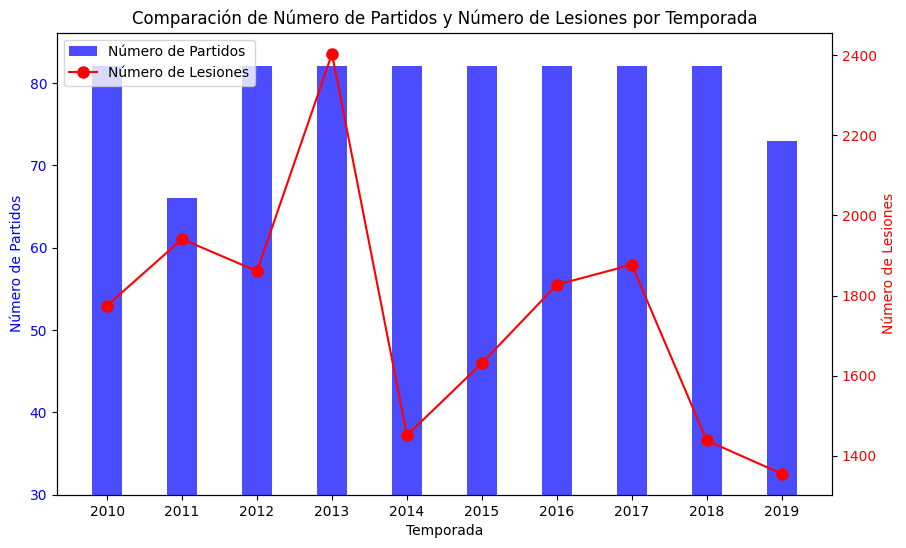

In [85]:
# Grafiquemos

fig, ax1 = plt.subplots(figsize=(10, 6))

# Ancho de las barras
bar_width = 0.4

# Barra para el número de partidos en el eje primario
bar1 = ax1.bar(df_merge['Temporada'], df_merge['N_partidos'].astype(int), label='Número de Partidos', width=bar_width, color='blue', alpha=0.7)

# Configurar el eje primario
ax1.set_xlabel('Temporada')
ax1.set_ylabel('Número de Partidos', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(bottom=30)

# Crear el eje secundario (twinx)
ax2 = ax1.twinx()

# Línea para el número de lesiones en el eje secundario
line1 = ax2.plot(df_merge['Temporada'], df_merge['Relinquished'], label='Número de Lesiones', color='red', marker='o', linestyle='-', markersize=8)

# Configurar el eje secundario
ax2.set_ylabel('Número de Lesiones', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Configurar el gráfico
plt.title('Comparación de Número de Partidos y Número de Lesiones por Temporada')
plt.xticks(df_merge.Temporada)

# Manejar las leyendas para ambos ejes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

En relación con el gráfico expuesto, podemos identificar que la temporada con más lesiones fue la del 2013-2014, aunque los datos que tenemos no nos permite concluir que el número de partidos fue la causa de dicha cantida de lesiones si podemos ver que posterior a un pico de lesiones, por lo general esta seguida de una caida abrupta de estas para las siguiente temporadas. También podemos ver que la menor cantidad de lesiones fue en la temporada 2019-2020, año que coincide con la pandemia de covid-19 donde hubo un parón en el calendario de partidos, y tras su reanudación los partidos se desarrolarron en una ambiente cerrado donde los jugdores permanecieron confinados durante el periodo de duración de esta, a esto se le llamo The Bubble.

## Estudiemos a los equipos

Para esta sección, de nuestro dataset inicial nos quedaremos con las columnas **Dates**, **Team**, **Relinquished** y **Notes**.

In [86]:
# Aislamos las columnas que nos pueden intresar

df_equipos = df_injuries[['Date','Team','Relinquished','Notes']]

# Eliminamos los valores nulos

df_equipos = df_equipos.dropna()
print(df_equipos.info())
df_equipos.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17558 entries, 0 to 27102
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          17558 non-null  datetime64[ns]
 1   Team          17558 non-null  object        
 2   Relinquished  17558 non-null  object        
 3   Notes         17558 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 685.9+ KB
None


,Date,Team,Relinquished,Notes
0,2010-10-03,Bulls,Carlos Boozer,fractured bone in right pinky finger (out inde...
1,2010-10-06,Pistons,Jonas Jerebko,torn right Achilles tendon (out indefinitely)
2,2010-10-06,Pistons,Terrico White,broken fifth metatarsal in right foot (out ind...
3,2010-10-08,Blazers,Jeff Ayres,torn ACL in right knee (out indefinitely)
4,2010-10-08,Nets,Troy Murphy,strained lower back (out indefinitely)


In [87]:
# Agrupamos el número de lesiones por equipo

df_equipos3 = df_equipos.groupby(by='Team').size().sort_values().reset_index()
df_equipos3.head()

,Team,0
0,Bobcats,276
1,Pelicans,384
2,Thunder,428
3,Blazers,434
4,Suns,456


A esta altura, nos encontramos con un pequeño inconveniente. Entre 2010 y 2013, el equipo de la ciudad de Nueva Orleans se denominaba "Hornets"; sin embargo, después de ese período, modificaron su nombre a "Pelicans". De manera similar, el equipo de la ciudad de Charlotte llevaba el nombre de "Bobcats" hasta 2014, momento en el cual cambió a "Hornets". Esto implica que necesitaremos ajustar los nombres de estos equipos en las fechas correspondientes.

Para visualizar cómo se distribuyó el número de lesiones a lo largo de la geografía de los Estados Unidos, planeamos representar en un mapa la ubicación de cada equipo de la NBA junto con su respectivo número de lesiones correspondiente.

In [88]:
# Modificamos el nombre de Hornets a Pelicans desde 2010 a 2013

df_equipos.loc[(df_equipos['Team']=='Hornets') & (df_equipos['Date']).between('2010-01-01','2013-06-20'),'Team']='Pelicans'

In [89]:
# Modificamos el nombre de Bobcats a Hornets

df_equipos.loc[(df_equipos['Team']=='Bobcats') & (df_equipos['Date']).between('2010-01-01','2020-06-15'),'Team']='Hornets'

# Agrupamos el número de lesiones por equipo y la asignamos a un nuevo dataset

df_equipos2 = df_equipos.groupby(by='Team').size().sort_values().reset_index()
df_equipos2.rename(columns={0:'Relinquished'}, inplace=True)
df_equipos2.head()

,Team,Relinquished
0,Thunder,428
1,Blazers,434
2,Suns,456
3,Kings,458
4,Pistons,462


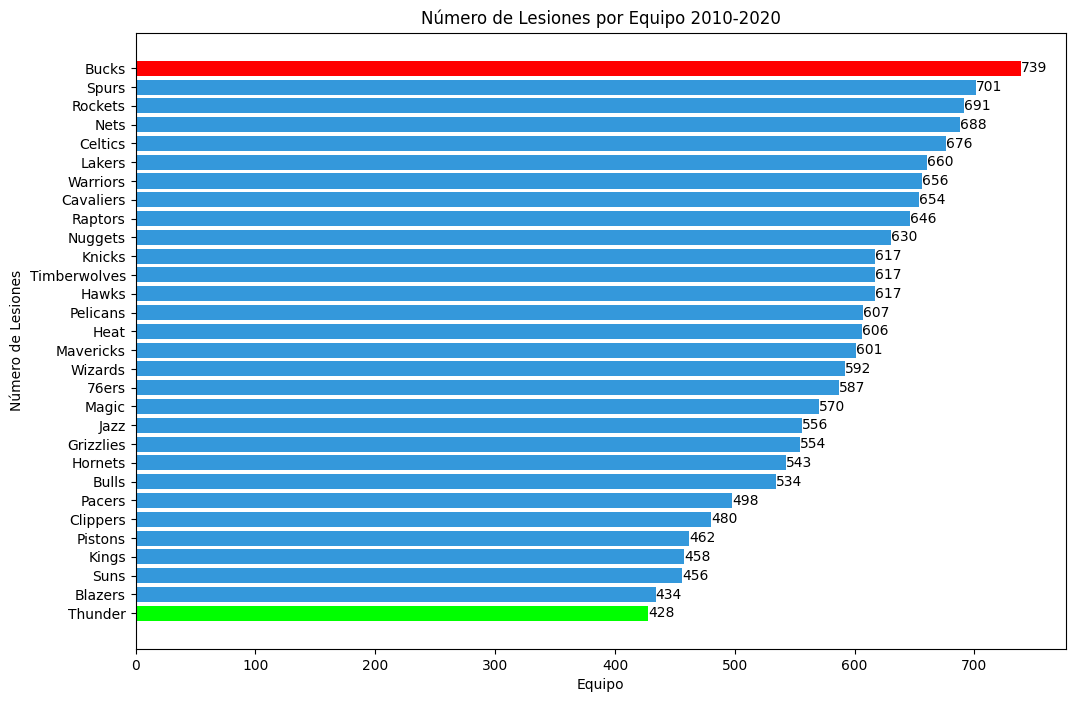

In [90]:
# Graficamos usando pyplot de matplotlib

plt.figure(figsize=(12, 8))

equipo_mas_lesiones = df_equipos2['Relinquished'].idxmax()
equipo_menos_lesiones = df_equipos2['Relinquished'].idxmin()

# identificamos con color rojo el equipo con más lesiones y con verde el equipo con menos lesiones
bar_colors = ['#FF0000' if equipo == df_equipos2.loc[equipo_mas_lesiones, 'Team'] else '#00FF00' if equipo == df_equipos2.loc[equipo_menos_lesiones, 'Team'] else '#3498db' for equipo in df_equipos2['Team']]

bar_plot = plt.barh(np.arange(len(df_equipos2['Team'])), df_equipos2['Relinquished'], color=bar_colors)

plt.xlabel('Equipo')
plt.ylabel('Número de Lesiones')
plt.title('Número de Lesiones por Equipo 2010-2020')

plt.yticks(np.arange(len(df_equipos2['Team'])), df_equipos2['Team'])

for bar in bar_plot:
    xval = bar.get_width()
    plt.text(xval, bar.get_y() + bar.get_height()/2, round(xval, 2), va='center', ha='left')

plt.show()

Utilizaremos el servicio OpenStreet Nominatim de la biblioteca geopy para encontrar la ubicación de los estadios de los equipos de la NBA y así poder representarlos en un mapa.

In [91]:
# Diccionario ficticio que asocia franquicias con ubicaciones

ubicaciones = {'Lakers': 'Crypto.com Arena', 'Celtics': 'TD Garden', 'Heat': 'FTX Arena', 'Bulls': 'United Center',
               'Warriors': 'Chase Center', 'Rockets': 'Toyota Center', 'Spurs': 'AT&T Center', 'Knicks': 'Madison Square Garden',
               'Clippers': 'Staples Center', 'Raptors': 'Scotiabank Arena', 'Mavericks': 'American Airlines Center', 'Nets': 'Barclays Center',
               '76ers': 'Wells Fargo Center', 'Nuggets': 'Ball Arena', 'Blazers': 'Moda Center', 'Magic': 'Amway Center',
               'Hawks': 'State Farm Arena', 'Pacers': 'Gainbridge Fieldhouse', 'Pelicans': 'Smoothie King Center', 'Grizzlies': 'FedEx Forum',
               'Wizards': 'Capital One Arena', 'Kings': 'Golden 1 Center', 'Hornets': 'Spectrum Center', 'Suns': 'Footprint Center',
               'Bucks': 'Fiserv Forum', 'Thunder': 'Chesapeake Energy Arena', 'Jazz': 'Delta Center', 'Timberwolves': 'Target Center',
               'Cavaliers': 'Rocket Mortgage FieldHouse','Pistons': 'Little Caesars Arena'}

# Inicializar el geocodificador de Nominatim
geolocator = Nominatim(user_agent="Estadiums")

coordenadas = {}

for key in ubicaciones:
  geolocator = Nominatim(user_agent="Estadiums")
  location = geolocator.geocode(ubicaciones[key])


  if location is not None:
    coordenadas[key] = location.latitude,location.longitude
  else:
    print(f"No se pudo encontrar la ubicación para {ubicaciones[key]}")


In [92]:
# Verifiquemos que obtuvimos las coordenadas geográficas

print(coordenadas)

{'Lakers': (34.0429979, -118.2671352463293), 'Celtics': (42.3662986, -71.06216222263835), 'Heat': (25.781359549999998, -80.18794351626137), 'Bulls': (41.88068305, -87.67418510441388), 'Warriors': (37.767892700000004, -122.38740721330376), 'Rockets': (29.75074725, -95.36223151477087), 'Spurs': (29.4270504, -98.43750706398404), 'Knicks': (40.750512900000004, -73.99351594545152), 'Clippers': (34.0429979, -118.2671352463293), 'Raptors': (43.64343375, -79.37907772483726), 'Mavericks': (32.7905076, -96.81027213460834), 'Nets': (40.68251055, -73.97525186658912), '76ers': (39.901100400000004, -75.17201654615069), 'Nuggets': (39.748683799999995, -105.00754401780362), 'Blazers': (45.5315787, -122.66683365218687), 'Magic': (28.53927385, -81.38400713924818), 'Hawks': (33.7573698, -84.39638483503104), 'Pacers': (39.7639331, -86.15550794973416), 'Pelicans': (29.94903925, -90.08206899587637), 'Grizzlies': (35.13779665, -90.05162430291487), 'Wizards': (38.8981883, -77.0209377602636), 'Kings': (38.5801

In [93]:
# Convertimos estas coordenadas en un dataframe

df_coordenadas = pd.DataFrame(coordenadas).transpose()
df_coordenadas.head()

,0,1
Lakers,34.042998,-118.267135
Celtics,42.366299,-71.062162
Heat,25.781360,-80.187944
Bulls,41.880683,-87.674185
Warriors,37.767893,-122.387407


In [94]:
# Renombramos las columnas

df_coordenadas.columns=['Latitud','Longitud']
df_coordenadas = df_coordenadas.rename_axis("Team")
df_coordenadas.reset_index().head()

,Team,Latitud,Longitud
0,Lakers,34.042998,-118.267135
1,Celtics,42.366299,-71.062162
2,Heat,25.781360,-80.187944
3,Bulls,41.880683,-87.674185
4,Warriors,37.767893,-122.387407


In [95]:
# Fucionamos los dataset df_equipos2 y df_coordenadas

df_team_lat_lon = pd.merge(df_equipos2,df_coordenadas, on = 'Team')
df_team_lat_lon.head()

,Team,Relinquished,Latitud,Longitud
0,Thunder,428,35.463396,-97.515082
1,Blazers,434,45.531579,-122.666834
2,Suns,456,33.446039,-112.071101
3,Kings,458,38.580140,-121.499501
4,Pistons,462,42.340977,-83.054955


In [96]:
# Obtenemos información y estadística de este nuevo dataset

df_team_lat_lon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          30 non-null     object 
 1   Relinquished  30 non-null     int64  
 2   Latitud       30 non-null     float64
 3   Longitud      30 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.2+ KB


In [97]:
df_team_lat_lon.describe(include='all')

,Team,Relinquished,Latitud,Longitud
count,30,30.000000,30.000000,30.000000
unique,30,NaN,NaN,NaN
top,Thunder,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,585.266667,37.316638,-93.250125
std,NaN,85.724070,5.291547,16.183699
min,NaN,428.000000,25.781360,-122.666834
25%,NaN,536.250000,33.828777,-103.365035
50%,NaN,603.500000,38.739164,-88.984556
75%,NaN,652.000000,41.314596,-80.975367


Crearemos un mapa de los Estados Unidos donde situaremos las sedes de cada equipo de la NBA y mostraremos el total de lesiones por equipo durante el periodo de 2010 a 2020. Utilizaremos dos bibliotecas fundamentales: folium para representar las sedes de los equipos con marcadores y pyplot para visualizar la densidad de lesiones por equipo mediante colores.

In [98]:
EEUU = folium.Map(location=[39.231373, -98.120941],zoom_start=5)
estadiums = folium.map.FeatureGroup()

for lat, lng, in zip(df_team_lat_lon.Latitud, df_team_lat_lon.Longitud):
    estadiums.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

latitudes = list(df_team_lat_lon.Latitud)
longitudes = list(df_team_lat_lon.Longitud)
labels = list(df_team_lat_lon.Relinquished.astype(str) + ', ' + df_team_lat_lon.Team.astype(str))

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(EEUU)

EEUU.add_child(estadiums)

In [99]:
# Graficamos en el mapa, la ubicación de las sedes de los equipos. Utilizaremos una escala de rojos para los valores de númer de lesiones por equipo.
fig = px.scatter_geo(
    df_team_lat_lon,
    lat='Latitud',
    lon='Longitud',
    text='Team',
    size='Relinquished',
    title='Número de Lesiones por Equipo de la NBA (2010-2020)',
    template='plotly',
    color='Relinquished',
    color_continuous_scale='reds',
    scope = 'usa',
    size_max=30
)

fig.update_geos(
    showcoastlines=True,
    coastlinecolor="Black",
    showland=True,
    landcolor="rgb(180, 217, 217)",
    showocean=True,
    oceancolor="rgb(204, 255, 255)",
    showcountries=True,
    showframe=False
)

fig.show()


Estamos intentando determinar si la ubicación geográfica puede tener alguna influencia en el número de lesiones. Sin embargo, como se observa en este último gráfico, no podemos afirmar que la sede de los equipos tenga un impacto significativo en la cantidad de lesiones de los jugadores.

## Conclusiones ##

1. Análisis de las Temporadas y el Impacto en las Lesiones:
En relación con el gráfico presentado, se destaca que la temporada con el mayor número de lesiones fue la del 2013-2014. Sin embargo, los datos disponibles no permiten concluir que el número de partidos haya sido la causa directa de esta cantidad de lesiones. Se observa que tras un pico de lesiones, generalmente se produce una caída abrupta en las temporadas siguientes. Un dato interesante es que la temporada 2019-2020 registró la menor cantidad de lesiones. Este año coincidió con la pandemia de COVID-19, durante la cual se produjo un parón en el calendario de partidos. Tras su reanudación, los partidos se llevaron a cabo en un ambiente cerrado conocido como "The Bubble", donde los jugadores permanecieron confinados durante el periodo de duración de la temporada.

2. Desempeño de Equipos en Términos de Lesiones:
Durante el periodo de estudio, se observa que el equipo con más lesiones fue Milwaukee Bucks, mientras que Oklahoma Thunder fue el equipo que registró menos lesiones.

3. Impacto de la Ubicación Geográfica en las Lesiones:
Se está explorando si la ubicación geográfica de los equipos puede influir en el número de lesiones. Sin embargo, el análisis de un gráfico reciente no muestra un impacto significativo de la sede de los equipos en la cantidad de lesiones de los jugadores.

Estas conclusiones sugieren la necesidad de explorar más a fondo otros factores que podrían contribuir al número de lesiones en la NBA, como las condiciones de juego, los programas de entrenamiento y las características individuales de los jugadores.

